In [1]:
import pandas as pd
import CococoNet_reader 
import os
import itertools
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import Name_resolver

In [2]:
def Calculate_Score_list_for_thresholding(Species_1 = 'rice',Species_2 = 'maize'):
    import pandas as pd
    import CococoNet_reader
    #Get Species Names in Common form 
    common_name_1 = Name_resolver.species_name_resolver(Species_1,'common')
    common_name_2 = Name_resolver.species_name_resolver(Species_2,'common')
    if common_name_1 == 'rice':
        common_name_1 = 'rice_jp'
    if common_name_2 == 'rice':
        common_name_2 ='rice_jp'

    file_list = os.listdir('/data/CoCoCoNet/orthologMaps')
    spec_1_filter = [i for i in file_list if common_name_1 in i]
    spec_2_filter = [i for i in spec_1_filter if common_name_2 in i]
    current_location = '/data/CoCoCoNet/orthologMaps/' + spec_2_filter[0] #get string for map

    cross_species_n_m_genes = pd.read_csv(current_location)
    orig_column_common_name_1 = common_name_1 + ' Symbol'
    orig_column_common_name_2 = common_name_2 + ' Symbol'
    cross_species_n_m_genes = cross_species_n_m_genes.rename(columns = {orig_column_common_name_1:common_name_1,orig_column_common_name_2:common_name_2})
    ### Get one to ones
    cross_species_map_one_to_one = cross_species_n_m_genes.drop_duplicates(subset=common_name_1, keep= False,)
    cross_species_map_one_to_one = cross_species_map_one_to_one.drop_duplicates(subset= common_name_2, keep= False)

    ## Convert to Dictionary
    dictionary_mapper_one_to_two = cross_species_map_one_to_one.set_index(common_name_1).to_dict()[common_name_2]
    dictionary_mapper_dos_to_uno = cross_species_map_one_to_one.set_index(common_name_2).to_dict()[common_name_1]

    ## Read In Cococonets 
    coconet_species_one = CococoNet_reader.read_cococonet(common_name_1)
    coconet_species_two = CococoNet_reader.read_cococonet(common_name_2)

    cross_species_n_m_genes['Group ID'] = 'Unassigned'


    ## Assign Genes to Groups
    id_indexer = 0
    for gene_pair in cross_species_n_m_genes.iterrows():
        
        if gene_pair[1]['Group ID'] == 'Unassigned':
            current_species_1_gene = gene_pair[1][common_name_1]
            current_species_2_gene = gene_pair[1][common_name_2]
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer

            all_labeled_groups = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == id_indexer]

            all_labeled_groups_species_1_genes = all_labeled_groups[common_name_1].to_list()
            all_labeled_groups_species_2_genes = all_labeled_groups[common_name_2].to_list()

            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_1].isin(all_labeled_groups_species_1_genes)] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_2].isin(all_labeled_groups_species_2_genes)] = id_indexer

            id_indexer += 1



    #Identify Pairs for evaluation
    all_pairs_to_evaluate_for_functional_conservation = pd.DataFrame(columns = [common_name_1,common_name_2,'Group Number'])
    for group_number in list(set(cross_species_n_m_genes['Group ID'].to_list())):
        current_gene_map = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == group_number]
        list_of_species_1_genes_in_group = list(set(current_gene_map[common_name_1].to_list()))
        list_of_species_2_genes_in_group = list(set(current_gene_map[common_name_2].to_list()))
        all_combo_list_current_genes = itertools.product(list_of_species_1_genes_in_group,list_of_species_2_genes_in_group)
        all_combo_list_current_genes = list(map(list,all_combo_list_current_genes))
        current_list_of_pairs = pd.DataFrame(all_combo_list_current_genes,columns = [common_name_1,common_name_2])
        current_list_of_pairs['Group Number'] = group_number
        all_pairs_to_evaluate_for_functional_conservation = pd.concat([all_pairs_to_evaluate_for_functional_conservation,current_list_of_pairs])



    all_pairs_to_evaluate_for_functional_conservation['Species 1 Score'] = np.nan
    all_pairs_to_evaluate_for_functional_conservation['Species 2 Score'] = np.nan


    ## Trim cococonets to match


    trimmed_species_1_cococonet = coconet_species_one[coconet_species_one.columns.intersection(cross_species_n_m_genes[common_name_1].to_list())]
    trimmed_species_1_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.index.isin(cross_species_n_m_genes[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = double_species_1_trimmed_cococonet.replace(1,0)

    trimmed_species_2_cococonet = coconet_species_two[coconet_species_two.columns.intersection(cross_species_n_m_genes[common_name_2].to_list())]
    trimmed_species_2_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.index.isin(cross_species_n_m_genes[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = double_species_2_trimmed_cococonet.replace(1,0)


    ## Rank
    species_1_cococonet_ranked = trimmed_species_1_cococonet.rank()
    species_2_cococonet_ranked = trimmed_species_2_cococonet.rank()

    #Do top 10 Genes
    top_10_species_1_genes = np.array(
        [double_species_1_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_1_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_1_genes_dataframe = pd.DataFrame(
        data=top_10_species_1_genes,
        index=double_species_1_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )

    #Convert 
    top_10_species_1_genes_as_species_2 = top_10_species_1_genes_dataframe.replace(to_replace=dictionary_mapper_one_to_two)

    # Get genes for checking 
    have_species_1_pairs = all_pairs_to_evaluate_for_functional_conservation.loc[all_pairs_to_evaluate_for_functional_conservation[common_name_1].isin(top_10_species_1_genes_as_species_2.index)]
    trimmed_all_gene_pairs_for_fc = have_species_1_pairs.loc[have_species_1_pairs[common_name_2].isin(trimmed_species_2_cococonet.index)]
    trimmed_all_gene_pairs_for_fc = trimmed_all_gene_pairs_for_fc.reset_index(drop = True)

    # Get values in species 2 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_1_genes_as_species_2.loc[current_species_1_gene].to_list()
        gene_ranks_in_species_2 = species_2_cococonet_ranked.loc[species_2_cococonet_ranked.index.isin(finger_print_genes), current_species_2_gene]
        avg_rank_in_species_2 = gene_ranks_in_species_2.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.at[index_from_pairs, 'Species 1 Score'] = avg_rank_in_species_2

    #Repeat for Species 2 

    top_10_species_2_genes = np.array(
        [double_species_2_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_2_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_2_genes_dataframe = pd.DataFrame(
        data=top_10_species_2_genes,
        index=double_species_2_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )


    #convert 
    top_10_species_2_genes_as_species_1 = top_10_species_2_genes_dataframe.replace(to_replace=dictionary_mapper_dos_to_uno)


    # Get values in species 1 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_2_genes_as_species_1.loc[current_species_2_gene].to_list()
        gene_ranks_in_species_1 = species_1_cococonet_ranked.loc[species_1_cococonet_ranked.index.isin(finger_print_genes), current_species_1_gene]
        avg_rank_in_species_1 = gene_ranks_in_species_1.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.loc[index_from_pairs, 'Species 2 Score'] = avg_rank_in_species_1

    #Caluclate Divisors 
    Number_of_species_1_genes = len(top_10_species_1_genes_as_species_2)
    Number_of_species_2_genes = len(top_10_species_2_genes_as_species_1)


    species_1_score_divisor = Number_of_species_2_genes - 4.5
    species_2_score_divisor = Number_of_species_1_genes-4.5

    #Divide and Average 
    trimmed_all_gene_pairs_for_fc['Species 1 Score'] = trimmed_all_gene_pairs_for_fc['Species 1 Score']/species_1_score_divisor
    trimmed_all_gene_pairs_for_fc['Species 2 Score'] = trimmed_all_gene_pairs_for_fc['Species 2 Score']/species_2_score_divisor
    trimmed_all_gene_pairs_for_fc['Total Score'] = trimmed_all_gene_pairs_for_fc[['Species 1 Score','Species 2 Score']].mean(axis = 1)
    trimmed_all_gene_pairs_for_fc['Species not arabi'] = Species_2

    return trimmed_all_gene_pairs_for_fc
    

In [3]:
list_of_mammals = ['chimp','crabm','boar','cow','dog','goat','horse','mouse','rabbit','rat','sheep','rhesusm', 'yeast', 'chicken']
human = ['human']
combinations_to_calculate_pairwise = list(itertools.product(human,list_of_mammals))
combinations_to_calculate_pairwise

[('human', 'chimp'),
 ('human', 'crabm'),
 ('human', 'boar'),
 ('human', 'cow'),
 ('human', 'dog'),
 ('human', 'goat'),
 ('human', 'horse'),
 ('human', 'mouse'),
 ('human', 'rabbit'),
 ('human', 'rat'),
 ('human', 'sheep'),
 ('human', 'rhesusm'),
 ('human', 'yeast'),
 ('human', 'chicken')]

In [4]:
# #full_score_table = pd.DataFrame()
# #for species_combination in combinations_to_calculate_pairwise:
# for species_combination in [['human','yeast'],['human','chicken']]:
#     species_1,species_2 = species_combination
#     print(species_combination)
#     current_n_m_score_table = Calculate_Score_list_for_thresholding(species_1,species_2)
#     full_score_table = pd.concat([full_score_table,current_n_m_score_table])


full_storage_location = f'/data/passala/Module_paper_data/human_vs_all_n_m/human_n_m_table_all_species.csv'
# full_score_table.to_csv(full_storage_location,index=False)
full_score_table = pd.read_csv(full_storage_location)

/tmp/ipykernel_803837/1043894882.py:12: DtypeWarning: Columns (1,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  full_score_table = pd.read_csv(full_storage_location)


In [5]:
full_score_table.loc[full_score_table['yeast'].notna() ]

,human,chimp,Group Number,Species 1 Score,Species 2 Score,Total Score,Species not arabi,crabm,boar,cow,dog,goat,horse,mouse,rabbit,rat,sheep,rhesusm,yeast,chicken
163418,ENSG00000065057,NaN,0,0.511746,0.661652,0.586699,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YOL043C,NaN
163419,ENSG00000065057,NaN,0,0.617779,0.575293,0.596536,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL015C,NaN
163420,ENSG00000105568,NaN,1,0.608372,0.860386,0.734379,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL016W,NaN
163421,ENSG00000137713,NaN,1,0.471509,0.675814,0.573662,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL016W,NaN
163422,ENSG00000167272,NaN,2,0.642042,0.876999,0.759521,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YAL033W,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170355,ENSG00000106443,NaN,1555,0.749077,0.649744,0.699410,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPR031W,NaN
170356,ENSG00000102886,NaN,1556,0.775770,0.584277,0.680023,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPL206C,NaN
170357,ENSG00000006007,NaN,1556,0.670623,0.673593,0.672108,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPL206C,NaN
170358,ENSG00000131558,NaN,1557,0.928934,0.817233,0.873083,yeast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YPR055W,NaN


In [6]:
merged_full_score_table = pd.concat([full_score_table["human"],full_score_table["Species 1 Score"],full_score_table["Species 2 Score"],full_score_table["Total Score"],full_score_table["Species not arabi"],
            full_score_table["crabm"].combine_first(full_score_table["boar"]).combine_first(full_score_table["cow"]).combine_first(full_score_table["cow"]).combine_first(full_score_table["dog"]).combine_first(full_score_table["goat"]).combine_first(full_score_table["horse"]).combine_first(full_score_table["mouse"]).combine_first(full_score_table["rabbit"]).combine_first(full_score_table["rat"]).combine_first(full_score_table["sheep"]).combine_first(full_score_table["rhesusm"]).combine_first(full_score_table["yeast"]).combine_first(full_score_table["chicken"])], axis=1)

In [7]:
merged_full_score_table = merged_full_score_table.reset_index(drop = True)
merged_full_score_table

,human,Species 1 Score,Species 2 Score,Total Score,Species not arabi,crabm
0,ENSG00000198700,0.956539,0.933936,0.945238,chimp,NaN
1,ENSG00000117450,0.976917,0.956495,0.966706,chimp,NaN
2,ENSG00000159388,0.896241,0.982463,0.939352,chimp,NaN
3,ENSG00000143368,0.985394,0.888593,0.936993,chimp,NaN
4,ENSG00000188157,0.952570,0.952639,0.952604,chimp,NaN
...,...,...,...,...,...,...
188510,ENSG00000168615,0.849242,0.857073,0.853157,chicken,ENSGALG00000003398
188511,ENSG00000168615,0.762297,0.708529,0.735413,chicken,ENSGALG00000009606
188512,ENSG00000110619,0.708957,0.838119,0.773538,chicken,ENSGALG00000006427
188513,ENSG00000197653,0.862328,0.798190,0.830259,chicken,ENSGALG00000043806


In [8]:
species_list = ['apple','rice', 'sorghum','maize','grape','mustard','soybean','medicago','potato','brome','tomato', "tobacco"]
age_list = [108,160,160,160,117,26,108,108,118,160,118, 118]

In [9]:
species_list = ['chimp','crabm','boar','cow','dog','goat','horse','mouse','rabbit','rat','sheep','rhesusm','chicken','yeast']
age_list = [6.4,28.8,94,94,94,94,94,87,87,87,94,28.8,319,1275]

In [10]:
merged_full_score_table['Time of Divergence'] = merged_full_score_table ['Species not arabi']
merged_full_score_table['Time of Divergence'] = merged_full_score_table['Time of Divergence'].replace(to_replace={'chimp':'0-40 MYA','crabm':'0-40 MYA','boar':'40-120 MYA','cow':'40-120 MYA','dog':'40-120 MYA','goat':'40-120 MYA','horse':'40-120 MYA','mouse':'40-120 MYA','rabbit':'40-120 MYA','rat':'40-120 MYA','sheep':'40-120 MYA','rhesusm':'0-40 MYA','chicken':'>120 MYA', 'yeast':'~1.5 Billion Years Ago'})

In [11]:
merged_full_score_table

,human,Species 1 Score,Species 2 Score,Total Score,Species not arabi,crabm,Time of Divergence
0,ENSG00000198700,0.956539,0.933936,0.945238,chimp,NaN,0-40 MYA
1,ENSG00000117450,0.976917,0.956495,0.966706,chimp,NaN,0-40 MYA
2,ENSG00000159388,0.896241,0.982463,0.939352,chimp,NaN,0-40 MYA
3,ENSG00000143368,0.985394,0.888593,0.936993,chimp,NaN,0-40 MYA
4,ENSG00000188157,0.952570,0.952639,0.952604,chimp,NaN,0-40 MYA
...,...,...,...,...,...,...,...
188510,ENSG00000168615,0.849242,0.857073,0.853157,chicken,ENSGALG00000003398,>120 MYA
188511,ENSG00000168615,0.762297,0.708529,0.735413,chicken,ENSGALG00000009606,>120 MYA
188512,ENSG00000110619,0.708957,0.838119,0.773538,chicken,ENSGALG00000006427,>120 MYA
188513,ENSG00000197653,0.862328,0.798190,0.830259,chicken,ENSGALG00000043806,>120 MYA


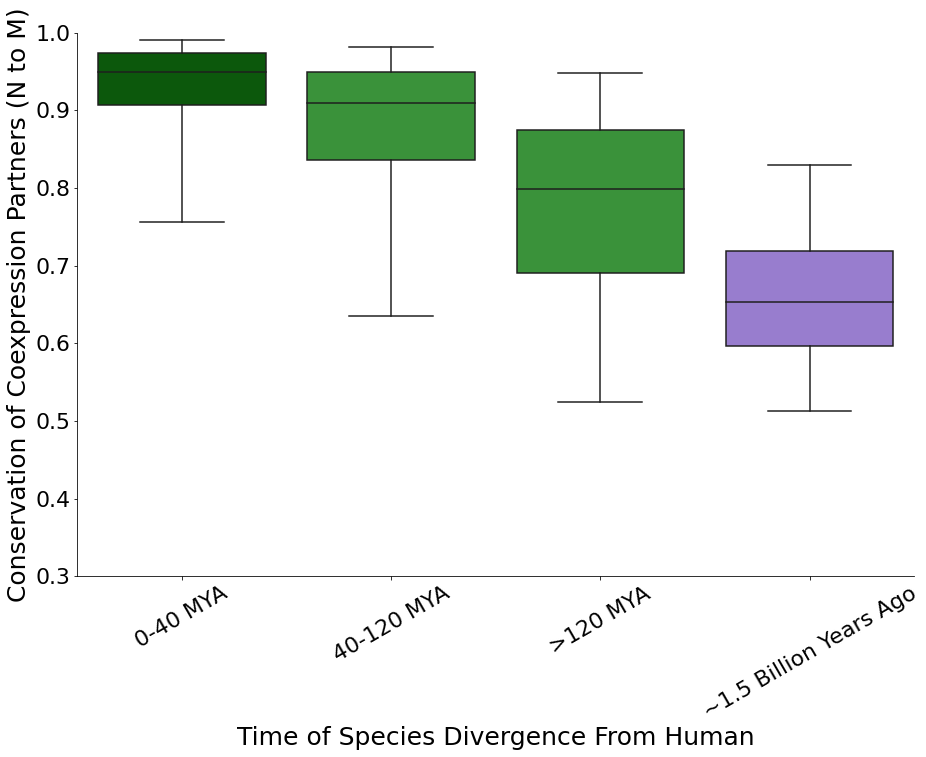

In [13]:
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.boxplot(data = merged_full_score_table, x = 'Time of Divergence',y = 'Total Score', fliersize = 0, whis =[5,95], order = ['0-40 MYA','40-120 MYA','>120 MYA','~1.5 Billion Years Ago'],palette = ['darkgreen','tab:green','tab:green','mediumpurple'])

fig.patch.set_facecolor('white')

sns.despine()

ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")

#plt.xlim(.5,.98)
plt.ylim(.3,1)
plt.xlabel("Time of Species Divergence From Human", fontsize = 25)
plt.ylabel("Conservation of Coexpression Partners (N to M)", fontsize = 25)


#plt.title("As Intra-Set Co-expresssion Increases, the Range of Functional Conservation Values Increases", fontsize = 25)
plt.xticks(fontsize = 22, rotation = 30)
plt.yticks(fontsize = 22)
#ax.set_xticklabels(labels = meta_cluster_labels_from_1_to_9)
#plt.legend(fontsize= 14,markerscale = 2.5, title = 'Gene', title_fontsize = 20)
plt.savefig('/data/passala/Module_paper_data/human_vs_all_n_m/N_M_decay.jpg',dpi = 800,bbox_inches='tight')

In [35]:
dict_of_ages = dict(zip(species_list,age_list))
dict_of_ages

{'apple': 108,
 'rice': 160,
 'sorghum': 160,
 'maize': 160,
 'grape': 117,
 'mustard': 26,
 'soybean': 108,
 'medicago': 108,
 'potato': 118,
 'brome': 160,
 'tomato': 118,
 'tobacco': 118}

In [36]:
merged_full_score_table['Divergence Age'] = merged_full_score_table['Species not arabi']
merged_full_score_table['Divergence Age']= merged_full_score_table['Divergence Age'].map(dict_of_ages)
merged_full_score_table

,arabidopsis,Species 1 Score,Species 2 Score,Total Score,Species not arabi,apple,Divergence Age,Gene Category
0,AT2G26300,0.567895,0.734409,0.651152,apple,LOC103441000,108,N to M
1,AT2G26300,0.612329,0.748048,0.680189,apple,LOC103455774,108,N to M
2,AT1G18450,0.805444,0.801265,0.803355,apple,LOC103448937,108,N to M
3,AT1G18450,0.888245,0.912502,0.900374,apple,LOC103432065,108,N to M
4,AT1G73910,0.722893,0.760890,0.741892,apple,LOC103448937,108,N to M
...,...,...,...,...,...,...,...,...
434027,AT3G59920,0.957392,0.955708,0.956550,tomato,LOC101259410,118,N to M
434028,AT3G59920,0.614687,0.361108,0.487897,tomato,GDI1,118,N to M
434029,AT2G44100,0.939508,0.976870,0.958189,tomato,LOC101261051,118,N to M
434030,AT2G44100,0.958798,0.975838,0.967318,tomato,LOC101259410,118,N to M


In [37]:
cleaned_full_score_table = merged_full_score_table.loc[merged_full_score_table['Species not arabi'] != 'tomato']
cleaned_full_score_table = cleaned_full_score_table.loc[cleaned_full_score_table['Species not arabi'] != 'soybean']
cleaned_full_score_table = cleaned_full_score_table.loc[cleaned_full_score_table['Species not arabi'] != 'brome']
cleaned_full_score_table = cleaned_full_score_table.loc[cleaned_full_score_table['Species not arabi'] != 'apple']

In [38]:
one_to_one = cleaned_full_score_table.drop_duplicates(subset = ['arabidopsis','Species not arabi'], keep= False)
one_to_one = one_to_one.drop_duplicates(subset = ['apple'])
one_to_one

,arabidopsis,Species 1 Score,Species 2 Score,Total Score,Species not arabi,apple,Divergence Age,Gene Category
68744,AT2G26300,0.667451,0.828804,0.748127,rice,Os05g0333200,160,One to One
68745,AT1G18450,0.960365,0.866949,0.913657,rice,Os08g0137200,160,One to One
68747,AT1G49040,1.000000,0.993666,0.996833,rice,Os01g0575500,160,One to One
68748,AT1G79120,0.840848,0.798547,0.819697,rice,Os03g0668400,160,One to One
68749,AT3G45740,0.680582,0.492242,0.586412,rice,Os03g0284500,160,One to One
...,...,...,...,...,...,...,...,...
394144,AT1G13190,0.904934,0.783611,0.844273,tobacco,LOC107774946,118,One to One
394237,AT1G78530,0.684967,0.601022,0.642994,tobacco,LOC107796836,118,One to One
394272,AT1G80190,0.819536,0.683305,0.751421,tobacco,LOC107791149,118,One to One
394304,AT1G48330,0.591658,0.526933,0.559296,tobacco,LOC107771279,118,One to One


<AxesSubplot:xlabel='Species not arabi', ylabel='Total Score'>

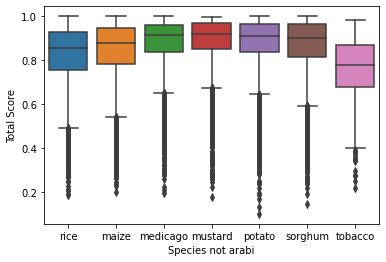

In [39]:
sns.boxplot(data = one_to_one, x = 'Species not arabi', y = 'Total Score')

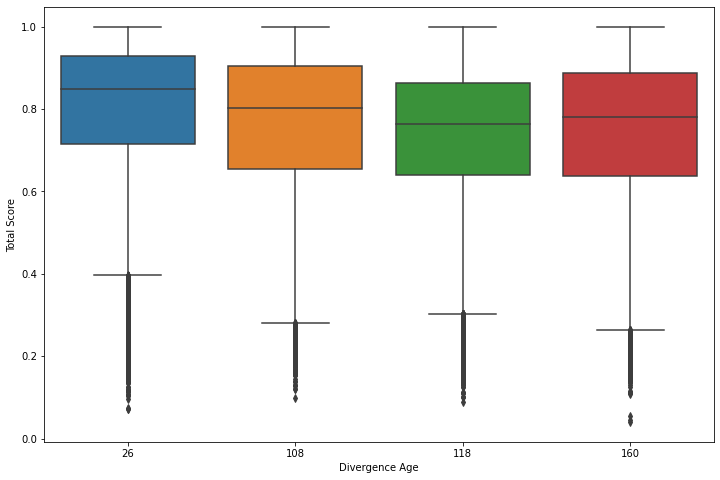

In [40]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.boxplot(data = cleaned_full_score_table, x = 'Divergence Age', y = 'Total Score')

In [32]:
one_to_one

,arabidopsis,Species 1 Score,Species 2 Score,Total Score,Species not arabi,apple,Divergence Age
68744,AT2G26300,0.667451,0.828804,0.748127,rice,Os05g0333200,NaN
68745,AT1G18450,0.960365,0.866949,0.913657,rice,Os08g0137200,NaN
68747,AT1G49040,1.000000,0.993666,0.996833,rice,Os01g0575500,NaN
68748,AT1G79120,0.840848,0.798547,0.819697,rice,Os03g0668400,NaN
68749,AT3G45740,0.680582,0.492242,0.586412,rice,Os03g0284500,NaN
...,...,...,...,...,...,...,...
394144,AT1G13190,0.904934,0.783611,0.844273,tobacco,LOC107774946,118.0
394237,AT1G78530,0.684967,0.601022,0.642994,tobacco,LOC107796836,118.0
394272,AT1G80190,0.819536,0.683305,0.751421,tobacco,LOC107791149,118.0
394304,AT1G48330,0.591658,0.526933,0.559296,tobacco,LOC107771279,118.0


In [41]:
one_to_one['Divergence Age'] = one_to_one['Divergence Age'].astype(int)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

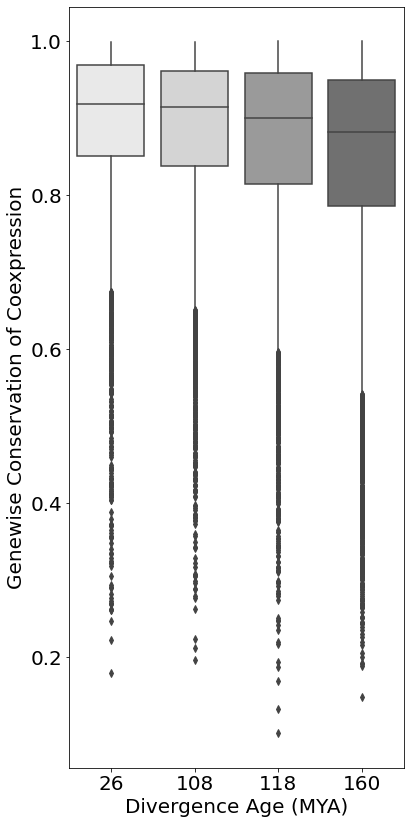

In [54]:
fig, ax = plt.subplots(figsize = (6,14))
fig.patch.set_facecolor('white')
ax = sns.boxplot(data = one_to_one, x = 'Divergence Age', y = 'Total Score', showcaps = False, palette= ['#e9e9e9','#d4d4d4','#9a9a9a','#707070'])
plt.xlabel( 'Divergence Age (MYA)',fontsize = 20)
plt.ylabel( 'Genewise Conservation of Coexpression', fontsize = 20)
plt.xticks(fontsize = 20, )
plt.yticks(fontsize = 20)


In [114]:
one_to_one.groupby('Divergence Age').mean()

,Species 1 Score,Species 2 Score,Total Score
Divergence Age,,,
26.0,0.881017,0.893659,0.887168
108.0,0.873806,0.883187,0.878497
118.0,0.861375,0.865318,0.863346
160.0,0.855523,0.857804,0.856663


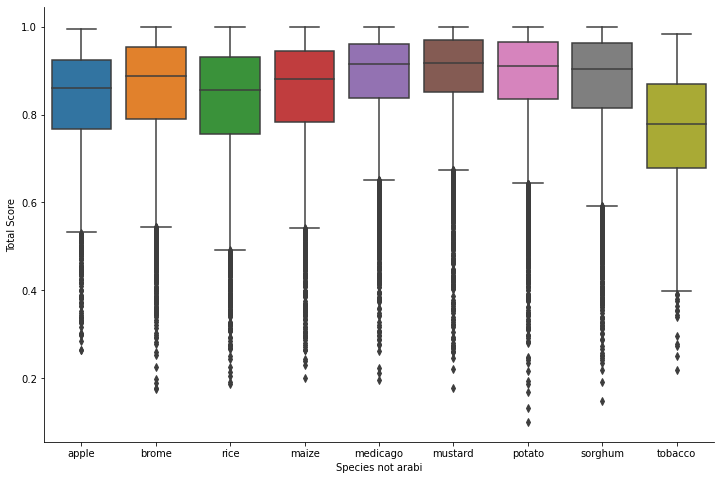

In [90]:
fig, ax = plt.subplots(figsize = (12,8))
fig.patch.set_facecolor('white')
ax = sns.boxplot(data = one_to_one, x = 'Species not arabi', y = 'Total Score')
# plt.ylabel("Expression Level (log2 CPM)", fontsize = 20)
# plt.xlabel("Cell Type", fontsize = 20)
# sns.despine()

#plt.xlabel("Target Gene Expression", fontsize = 20)
#plt.ylabel("Potential Coexpressolog Gene Expression", fontsize = 20)
sns.despine()
#ax.set(xscale = 'log',yscale = 'log')
ax.grid(False)
ax.spines["bottom"].set_color("black")
#ax.spines['bottom'].set_linewidth(2)
ax.spines["left"].set_color("black")
#ax.spines['left'].set_linewidth(2)
# plt.xlim((0,3))
# plt.ylim((0, 3))
# handles, labels  =  ax.get_legend_handles_labels()
# ax.legend(handles, ['Accepted Coexpressolog', 'Rejected Coexpressolog'], bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0,)
# #plt.title("Current Threshold is 31", fontsize = 20)
# plt.xticks(fontsize = 12, rotation = 25)
# #plt.yticks(fontsize = 11)
# ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle = 'dashed', color = 'k', linewidth = 1.5)

In [16]:
merged_full_score_table['Gene Category'] = 'N to M'
merged_full_score_table['Gene Category'].loc[merged_full_score_table.index.isin(one_to_one.index)] = 'One to One'
merged_full_score_table

/tmp/ipykernel_2362576/362719988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_full_score_table['Gene Category'].loc[merged_full_score_table.index.isin(one_to_one.index)] = 'One to One'


,arabidopsis,Species 1 Score,Species 2 Score,Total Score,Species not arabi,apple,Divergence Age,Gene Category
0,AT2G26300,0.567895,0.734409,0.651152,apple,LOC103441000,108.0,N to M
1,AT2G26300,0.612329,0.748048,0.680189,apple,LOC103455774,108.0,N to M
2,AT1G18450,0.805444,0.801265,0.803355,apple,LOC103448937,108.0,N to M
3,AT1G18450,0.888245,0.912502,0.900374,apple,LOC103432065,108.0,N to M
4,AT1G73910,0.722893,0.760890,0.741892,apple,LOC103448937,108.0,N to M
...,...,...,...,...,...,...,...,...
434027,AT3G59920,0.957392,0.955708,0.956550,tomato,LOC101259410,118.0,N to M
434028,AT3G59920,0.614687,0.361108,0.487897,tomato,GDI1,118.0,N to M
434029,AT2G44100,0.939508,0.976870,0.958189,tomato,LOC101261051,118.0,N to M
434030,AT2G44100,0.958798,0.975838,0.967318,tomato,LOC101259410,118.0,N to M


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

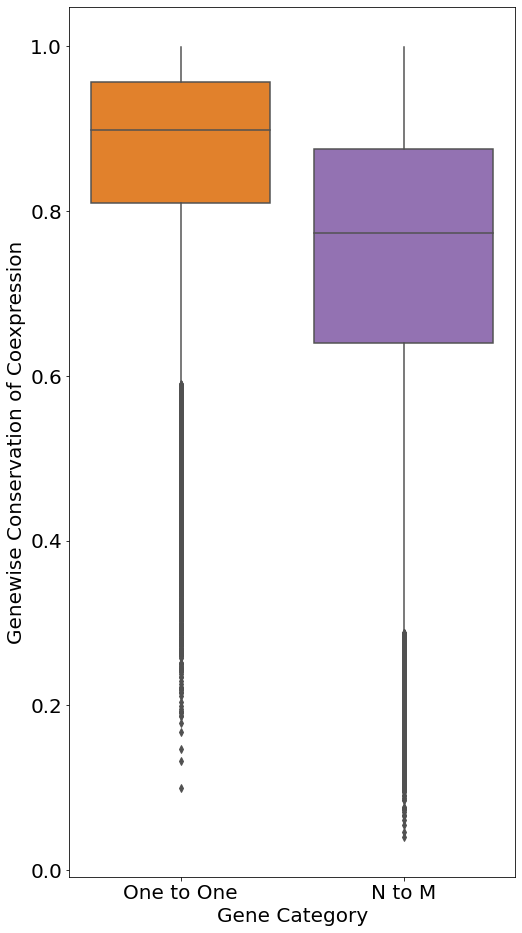

In [28]:
fig, ax = plt.subplots(figsize = (8,16))
fig.patch.set_facecolor('white')
sns.boxplot(data = merged_full_score_table, x = 'Gene Category', y = 'Total Score', order = ['One to One','N to M'], palette = ['tab:orange','tab:purple'], showcaps = False )
plt.xlabel( 'Gene Category',fontsize = 20)
plt.ylabel( 'Genewise Conservation of Coexpression', fontsize = 20)
plt.xticks(fontsize = 20, )
plt.yticks(fontsize = 20)